# FoDS Project: Covid 

## 1 Preparation

### Structure 
1. Setting up the environment
2. Importing the data

### 1. Environment
1. python == 3.11.8 
2. matplotlib=3.8.3
3. numpy=1.26.0
4. pandas=2.1.1
5. scipy=1.12.0
6. seaborn=0.13.2
7. sklearn=1.4.2

In [749]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import StratifiedKFold
from scipy.stats import boxcox
import warnings
warnings.filterwarnings("ignore")

### 2. Importing Data

In [750]:
data = pd.read_csv("../data/OWID-covid-data-28Feb2023.csv")

## 2 Getting an overview

### Structure
1. Basic overview
2. Datatypes
3. Locations and continents

### 1. Basic overview

In [751]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260567 entries, 0 to 260566
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    260567 non-null  object 
 1   continent                                   245944 non-null  object 
 2   location                                    260567 non-null  object 
 3   date                                        260567 non-null  object 
 4   total_cases                                 246027 non-null  float64
 5   new_cases                                   245704 non-null  float64
 6   new_cases_smoothed                          244500 non-null  float64
 7   total_deaths                                226322 non-null  float64
 8   new_deaths                                  226220 non-null  float64
 9   new_deaths_smoothed                         225034 non-null  float64
 

In [752]:
print(data.describe())

        total_cases     new_cases  new_cases_smoothed  total_deaths     new_deaths  new_deaths_smoothed  total_cases_per_million  new_cases_per_million  new_cases_smoothed_per_million  total_deaths_per_million  new_deaths_per_million  new_deaths_smoothed_per_million  reproduction_rate  icu_patients  icu_patients_per_million  hosp_patients  hosp_patients_per_million  weekly_icu_admissions  weekly_icu_admissions_per_million  weekly_hosp_admissions  weekly_hosp_admissions_per_million   total_tests     new_tests  total_tests_per_thousand  new_tests_per_thousand  new_tests_smoothed  new_tests_smoothed_per_thousand  positive_rate  tests_per_case  total_vaccinations  people_vaccinated  people_fully_vaccinated  total_boosters  new_vaccinations  new_vaccinations_smoothed  total_vaccinations_per_hundred  people_vaccinated_per_hundred  people_fully_vaccinated_per_hundred  total_boosters_per_hundred  new_vaccinations_smoothed_per_million  new_people_vaccinated_smoothed  \
count  2.460270e+05  2.45

In [753]:
print(data.head())

  iso_code continent     location        date  total_cases  new_cases  new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  total_cases_per_million  new_cases_per_million  new_cases_smoothed_per_million  total_deaths_per_million  new_deaths_per_million  new_deaths_smoothed_per_million  reproduction_rate  icu_patients  icu_patients_per_million  hosp_patients  hosp_patients_per_million  weekly_icu_admissions  weekly_icu_admissions_per_million  weekly_hosp_admissions  weekly_hosp_admissions_per_million  total_tests  new_tests  total_tests_per_thousand  new_tests_per_thousand  new_tests_smoothed  new_tests_smoothed_per_thousand  positive_rate  tests_per_case tests_units  total_vaccinations  people_vaccinated  people_fully_vaccinated  total_boosters  new_vaccinations  new_vaccinations_smoothed  total_vaccinations_per_hundred  people_vaccinated_per_hundred  people_fully_vaccinated_per_hundred  total_boosters_per_hundred  new_vaccinations_smoothed_per_million  \
0      AFG      

In [754]:
print(data.tail())

       iso_code continent  location        date  total_cases  new_cases  new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  total_cases_per_million  new_cases_per_million  new_cases_smoothed_per_million  total_deaths_per_million  new_deaths_per_million  new_deaths_smoothed_per_million  reproduction_rate  icu_patients  icu_patients_per_million  hosp_patients  hosp_patients_per_million  weekly_icu_admissions  weekly_icu_admissions_per_million  weekly_hosp_admissions  weekly_hosp_admissions_per_million  total_tests  new_tests  total_tests_per_thousand  new_tests_per_thousand  new_tests_smoothed  new_tests_smoothed_per_thousand  positive_rate  tests_per_case tests_units  total_vaccinations  people_vaccinated  people_fully_vaccinated  total_boosters  new_vaccinations  new_vaccinations_smoothed  total_vaccinations_per_hundred  people_vaccinated_per_hundred  people_fully_vaccinated_per_hundred  total_boosters_per_hundred  new_vaccinations_smoothed_per_million  \
260562      ZW

In [755]:
print("Number of observations:", data.shape[0])
print("Number of columns:", data.shape[1])

Number of observations: 260567
Number of columns: 67


### 2. Datatypes

#### 2.1 All datatypes

In [756]:
#Datatypes of each variable:
print(data.dtypes)

iso_code                                       object
continent                                      object
location                                       object
date                                           object
total_cases                                   float64
new_cases                                     float64
new_cases_smoothed                            float64
total_deaths                                  float64
new_deaths                                    float64
new_deaths_smoothed                           float64
total_cases_per_million                       float64
new_cases_per_million                         float64
new_cases_smoothed_per_million                float64
total_deaths_per_million                      float64
new_deaths_per_million                        float64
new_deaths_smoothed_per_million               float64
reproduction_rate                             float64
icu_patients                                  float64
icu_patients_per_million    

#### 2.2 Integers

In [757]:
int_data = data.select_dtypes(include=("int64")).columns
print("INTEGERS: ", int_data)

INTEGERS:  Index([], dtype='object')


It seems we do not have any integers in our data. (We have but they are just not saved as such)

#### 2.3 Floats

In [758]:
float_data = data.select_dtypes(include=("float64")).columns
print("FLOATS: ", float_data)

FLOATS:  Index(['total_cases', 'new_cases', 'new_cases_smoothed', 'total_deaths', 'new_deaths', 'new_deaths_smoothed', 'total_cases_per_million', 'new_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million', 'new_deaths_per_million', 'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients', 'icu_patients_per_million', 'hosp_patients', 'hosp_patients_per_million', 'weekly_icu_admissions', 'weekly_icu_admissions_per_million', 'weekly_hosp_admissions', 'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests', 'total_tests_per_thousand', 'new_tests_per_thousand', 'new_tests_smoothed', 'new_tests_smoothed_per_thousand', 'positive_rate', 'tests_per_case', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated', 'total_boosters', 'new_vaccinations', 'new_vaccinations_smoothed', 'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred', 'total_boosters_per_hundred',
       'new_vaccinatio

#### 2.4 Objects

In [759]:
object_data = data.select_dtypes(include=("object")).columns
print("OBJECTS:", object_data)
num_data = data[float_data] 

OBJECTS: Index(['iso_code', 'continent', 'location', 'date', 'tests_units'], dtype='object')


#### 2.5 Saving numerical and categorical data in seperate data frames

In [760]:
num_data = data[float_data] 
cat_data = data[object_data]

## 3 Missing Data Analysis


### Structure


1. Introductory remarks about OWID
2. Preparatory steps
3. First overview of missing data
4. Overview missing data "cases" and "deaths"
5. Total cases continent analysis
6. Factual accuracy
7. Country analysis


### 1. Introductory remarks about OWID

OWID itself states that it generally takes its data from 4 different sources:
1. Specialized institutes
2. Research articles
3. International Institutations or statistics agencies
4. Official data from government sources

More specifically, looking at the OWID COVID dataset online where all the sources are indicated, it can be seen that OWID takes most of the data directly from the WHO COVID dashboard and then completes it with other sources which is why this dataset can be expected to be quite complete. However, the following analysis is attempting to analyze how much data is missing from the dataset and what kind of data is missing. 

### 2. Preparatory steps

#### 2.1 Adjusting visualization settings

In [761]:
# Define colorblind-friendly palette
color_palette = sns.color_palette("colorblind")

In [762]:
#adjusting the viewing options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#### 2.2 Data Cleaning


In [763]:
#dropping duplicates
data = data.drop_duplicates()

#separating OWID from non_OWID data
data_without_OWID = data[~data['iso_code'].str.contains('OWID')]
data_OWID = data[data['iso_code'].str.contains('OWID')]

### 3. First overview of missing data

#### 3.1 Entries with complete information

In [764]:
#For how many entries do we have complete information?
(data.isna().sum(axis=1) == 0).sum()

0

#### 3.2 Missing values per column overall

In [765]:
#missing values overall per column
total_missing = data.isnull().sum()
total_missing_percentage = (total_missing / len(data)) * 100
total_missing_sorted = total_missing.sort_values()
total_missing_percentage_sorted = total_missing_percentage.sort_values()

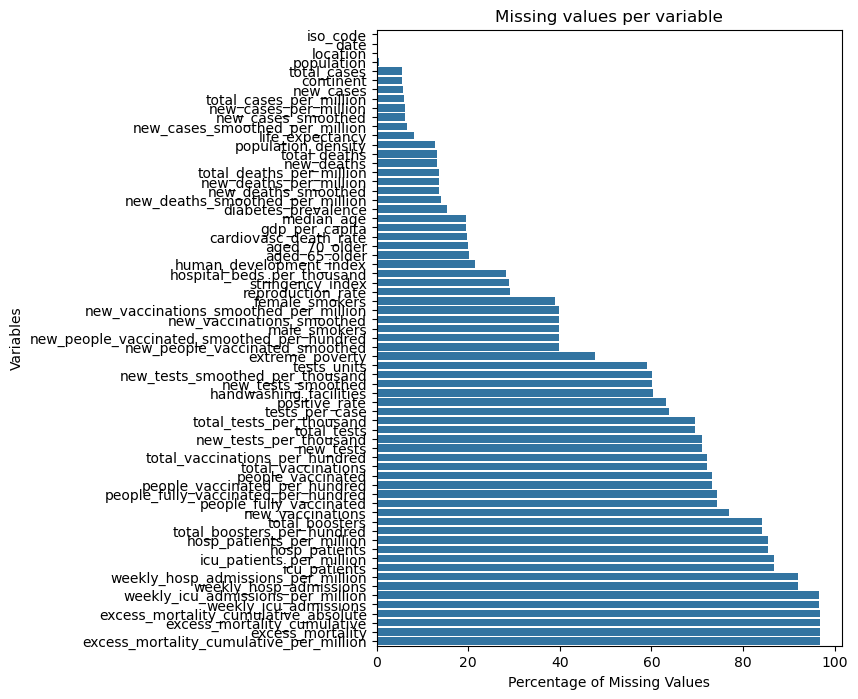

In [766]:
#graphing the missing values per column
plt.figure(figsize=(6, 8))
fig_mv_variables = sns.barplot(
    x = total_missing_percentage_sorted.values,
    y = total_missing_percentage_sorted.index
)
fig_mv_variables.set(
    title="Missing values per variable",
    xlabel="Percentage of Missing Values",
    ylabel="Variables"
)
plt.savefig("../output/Missing_Data_Analysis/missing_data.png", bbox_inches="tight")              

### 4. Overview missing data "cases" and "deaths"

#### 4.1 Selecting only the columns containing information about cases and deaths

In [767]:
#selecting the columns about cases of interest
columns_about_cases = data.loc[:, data.columns.str.contains('cases')]
columns_about_cases.columns

Index(['total_cases', 'new_cases', 'new_cases_smoothed', 'total_cases_per_million', 'new_cases_per_million', 'new_cases_smoothed_per_million'], dtype='object')

In [768]:
columns_about_deaths = data.loc[:, data.columns.str.contains('death')]
columns_about_deaths.columns

Index(['total_deaths', 'new_deaths', 'new_deaths_smoothed', 'total_deaths_per_million', 'new_deaths_per_million', 'new_deaths_smoothed_per_million', 'cardiovasc_death_rate'], dtype='object')

#### 4.2 Sorting and plotting overall missing data about cases

In [769]:
def missing_data_filtered(columns_of_interest):
    total_missing = columns_of_interest.isnull().sum()
    total_missing_percentage = (total_missing / len(data)) * 100
    total_missing_sorted = total_missing.sort_values()
    total_missing_percentage_sorted = total_missing_percentage.sort_values()
    return total_missing_percentage_sorted

total_missing_percentage_deaths_sorted = missing_data_filtered(columns_about_deaths)

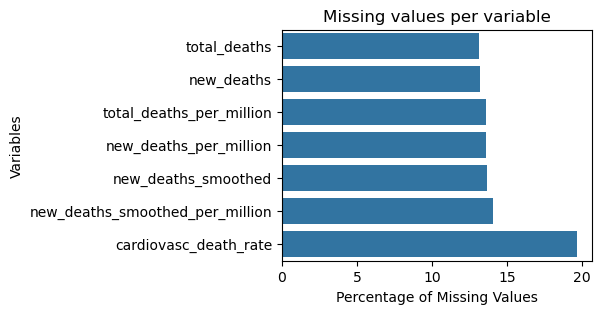

In [770]:
plt.figure(figsize=(4, 3))
deaths_overview = sns.barplot(
    x = total_missing_percentage_deaths_sorted.values,
    y = total_missing_percentage_deaths_sorted.index
)
deaths_overview.set(
    title="Missing values per variable",
    xlabel="Percentage of Missing Values",
    ylabel="Variables"
)
plt.savefig("../output/Missing_Data_Analysis/deathsmissing_data.png", bbox_inches="tight")  

#### 4.3 Sorting and plotting overall missing data about deaths

In [771]:
total_missing_percentage_cases_sorted = missing_data_filtered(columns_about_cases)

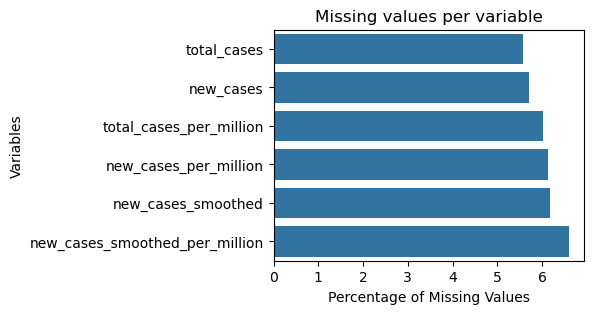

In [772]:
plt.figure(figsize=(4, 3))
cases_overview = sns.barplot(
    x = total_missing_percentage_cases_sorted.values,
    y = total_missing_percentage_cases_sorted.index
)
cases_overview.set(
    title="Missing values per variable",
    xlabel="Percentage of Missing Values",
    ylabel="Variables"
)
plt.savefig("../output/Missing_Data_Analysis/casesmissing_data.png", bbox_inches="tight") 

There is in the overall dataset a lot more data around cases than deaths. However, amongst the columns that give information about either death or cases, the variability as to the amount of missing data is low.

### 5 Total cases continent analysis


#### 5.1 Amount of data per country

Comment: Since reporting is generally done on a national level, it makes sense to have a look at individual countries to find out where potential data is missing.

In [773]:
#how many countries are we dealing with overall
unique_values_world = data_without_OWID['iso_code'].unique()
print (len(unique_values_world))

229


In [774]:
#calculating the number of entries for each country
length_list = []
length_list_in_years = []

for i in range(len(unique_values_world)):
    country = unique_values_world[i]
    length_country = len(data_without_OWID.loc[df['iso_code'] == country])
    length_list.append(length_country)
    length_list_in_years.append(length_country/365)

sorted_country_length = sorted(length_list)

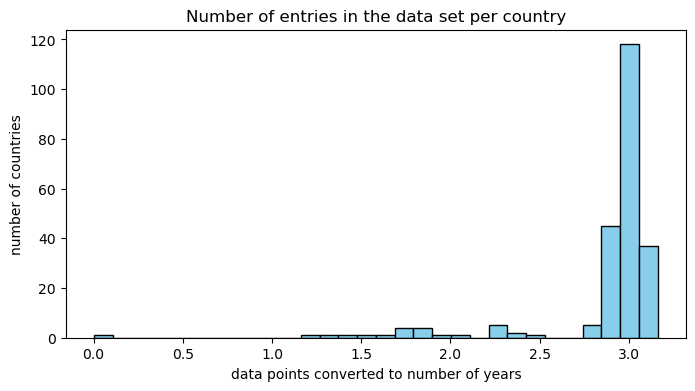

In [775]:
plt.figure(figsize=(8, 4))
plt.hist(length_list_in_years, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('data points converted to number of years')
plt.ylabel('number of countries')
plt.title("Number of entries in the data set per country")
plt.show()

#### 5.2 Total cases Asia


In [776]:
#different continents
filtered_continents = data_without_OWID["continent"].unique()
filtered_continents

array(['Asia', 'Europe', 'Africa', 'North America', 'South America',
       'Oceania'], dtype=object)

In [777]:
#function returning list of all different countries on one continent
def countries_per_continent(continent):
    filtered_continent = data_without_OWID.loc[df['continent'] == continent]
    unique_values_continent = filtered_continent['iso_code'].unique()
    return unique_values_continent

unique_values_Asia = countries_per_continent("Asia")
unique_values_Asia

array(['AFG', 'ARM', 'AZE', 'BHR', 'BGD', 'BTN', 'BRN', 'KHM', 'CHN',
       'GEO', 'HKG', 'IND', 'IDN', 'IRN', 'IRQ', 'ISR', 'JPN', 'JOR',
       'KAZ', 'KWT', 'KGZ', 'LAO', 'LBN', 'MAC', 'MYS', 'MDV', 'MNG',
       'MMR', 'NPL', 'PRK', 'OMN', 'PAK', 'PSE', 'PHL', 'QAT', 'SAU',
       'SGP', 'KOR', 'LKA', 'SYR', 'TWN', 'TJK', 'THA', 'TLS', 'TUR',
       'TKM', 'ARE', 'UZB', 'VNM', 'YEM'], dtype=object)

In [778]:
def continent_values(continent_uniq_val):
    values = []
    for i in range(len(continent_uniq_val)):
        currentcountry = continent_uniq_val[i]
        filtered_country = data.loc[df['iso_code'] == currentcountry]
        no_rows_current_country = len(filtered_country)
        missing = (filtered_country["total_cases"].isnull().sum())
        total_missing_percentage_current_country = (missing / len(filtered_country)) * 100
        values.append(total_missing_percentage_current_country)
    return values

values_Asia = continent_values(unique_values_Asia)

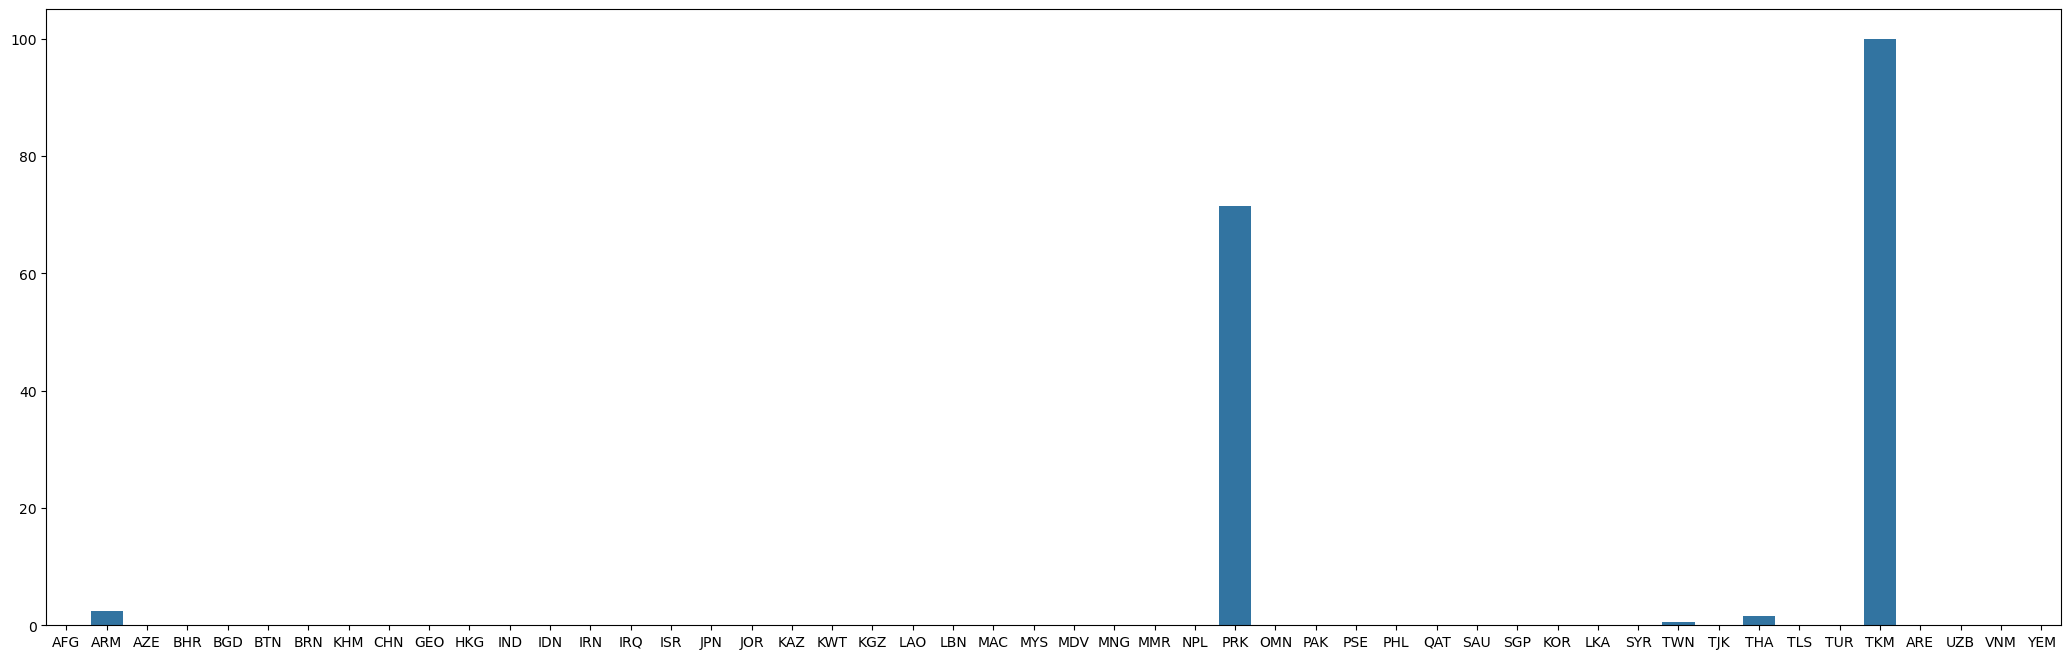

In [779]:
def plotting_barplot_continent (unique_codes, values):
    plt.figure(figsize=(26, 8))
    missing_values_Asia = sns.barplot(
        x = unique_codes,
        y = values
    )

    deaths_overview.set(
        title="Missing values per variable",
        xlabel="Percentage of Missing Values",
        ylabel="Variables"
    )

    plt.savefig("../output/Missing_Data_Analysis/casesmissing_data2.png", bbox_inches="tight") 

plotting_barplot_continent(unique_values_Asia, values_Asia)

#### 5.3 Total Cases Europe

In [780]:
unique_values_Europe = countries_per_continent("Europe")
unique_values_Europe

array(['ALB', 'AND', 'AUT', 'BLR', 'BEL', 'BIH', 'BGR', 'HRV', 'CYP',
       'CZE', 'DNK', 'EST', 'FRO', 'FIN', 'FRA', 'DEU', 'GIB', 'GRC',
       'GGY', 'HUN', 'ISL', 'IRL', 'IMN', 'ITA', 'JEY', 'LVA', 'LIE',
       'LTU', 'LUX', 'MLT', 'MDA', 'MCO', 'MNE', 'NLD', 'MKD', 'NOR',
       'POL', 'PRT', 'ROU', 'RUS', 'SMR', 'SRB', 'SVK', 'SVN', 'ESP',
       'SWE', 'CHE', 'UKR', 'GBR', 'VAT'], dtype=object)

In [781]:
values_Europe = continent_values(unique_values_Europe)

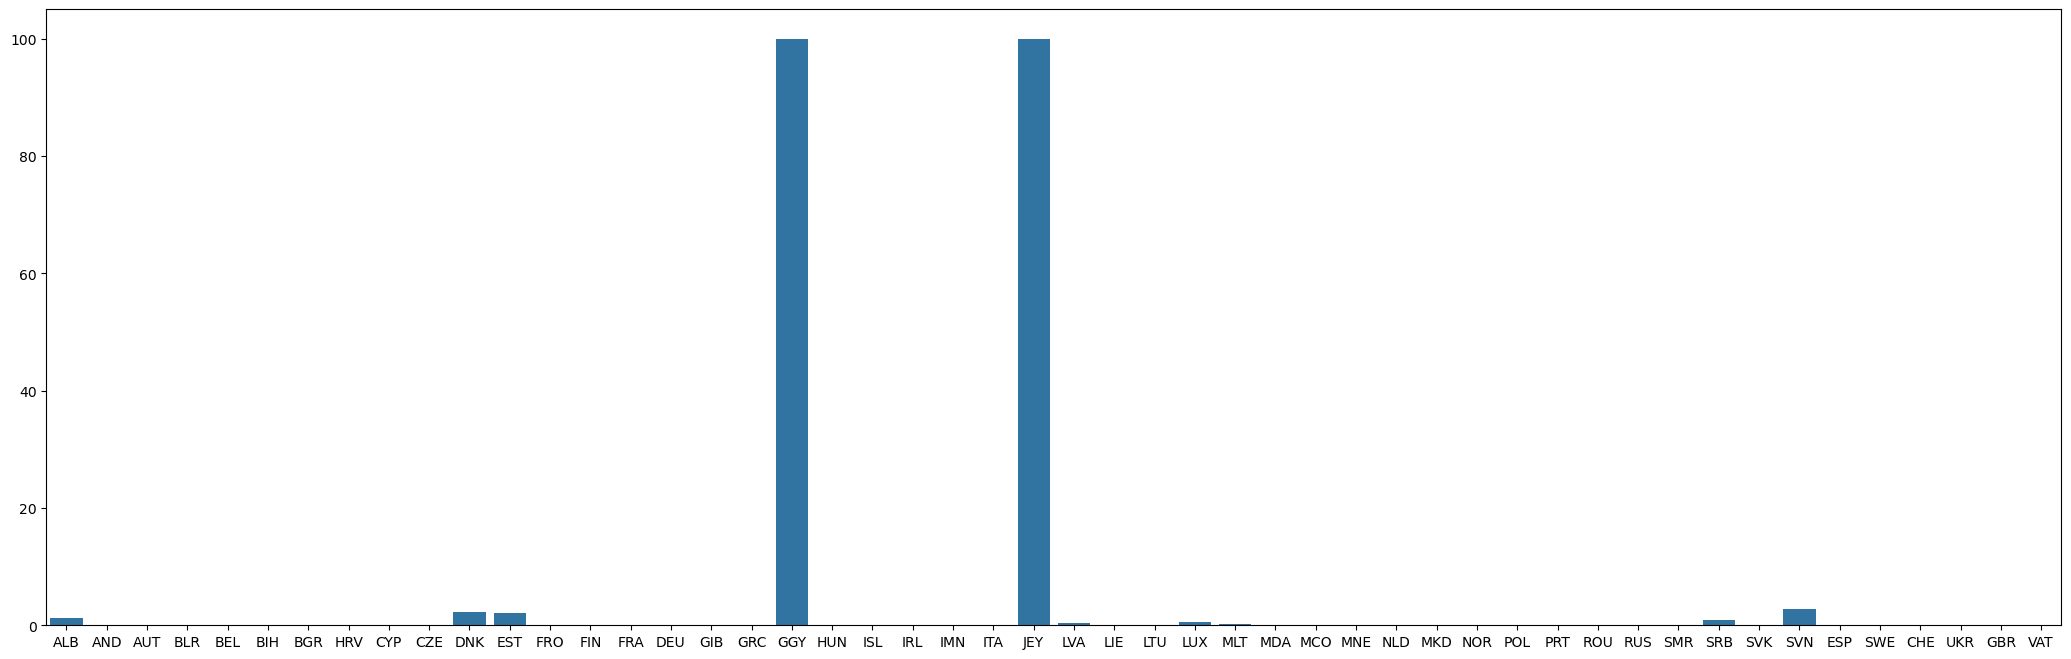

In [782]:
plotting_barplot_continent(unique_values_Europe, values_Europe)

#### 5.4 Total Cases Africa

In [783]:
unique_values_Africa = countries_per_continent("Africa")
unique_values_Africa

array(['DZA', 'AGO', 'BEN', 'BWA', 'BFA', 'BDI', 'CMR', 'CPV', 'CAF',
       'TCD', 'COM', 'COG', 'CIV', 'COD', 'DJI', 'EGY', 'GNQ', 'ERI',
       'SWZ', 'ETH', 'GAB', 'GMB', 'GHA', 'GIN', 'GNB', 'KEN', 'LSO',
       'LBR', 'LBY', 'MDG', 'MWI', 'MLI', 'MRT', 'MUS', 'MAR', 'MOZ',
       'NAM', 'NER', 'NGA', 'RWA', 'SHN', 'STP', 'SEN', 'SYC', 'SLE',
       'SOM', 'ZAF', 'SSD', 'SDN', 'TZA', 'TGO', 'TUN', 'UGA', 'ESH',
       'ZMB', 'ZWE'], dtype=object)

In [784]:
values_Africa = continent_values(unique_values_Africa)

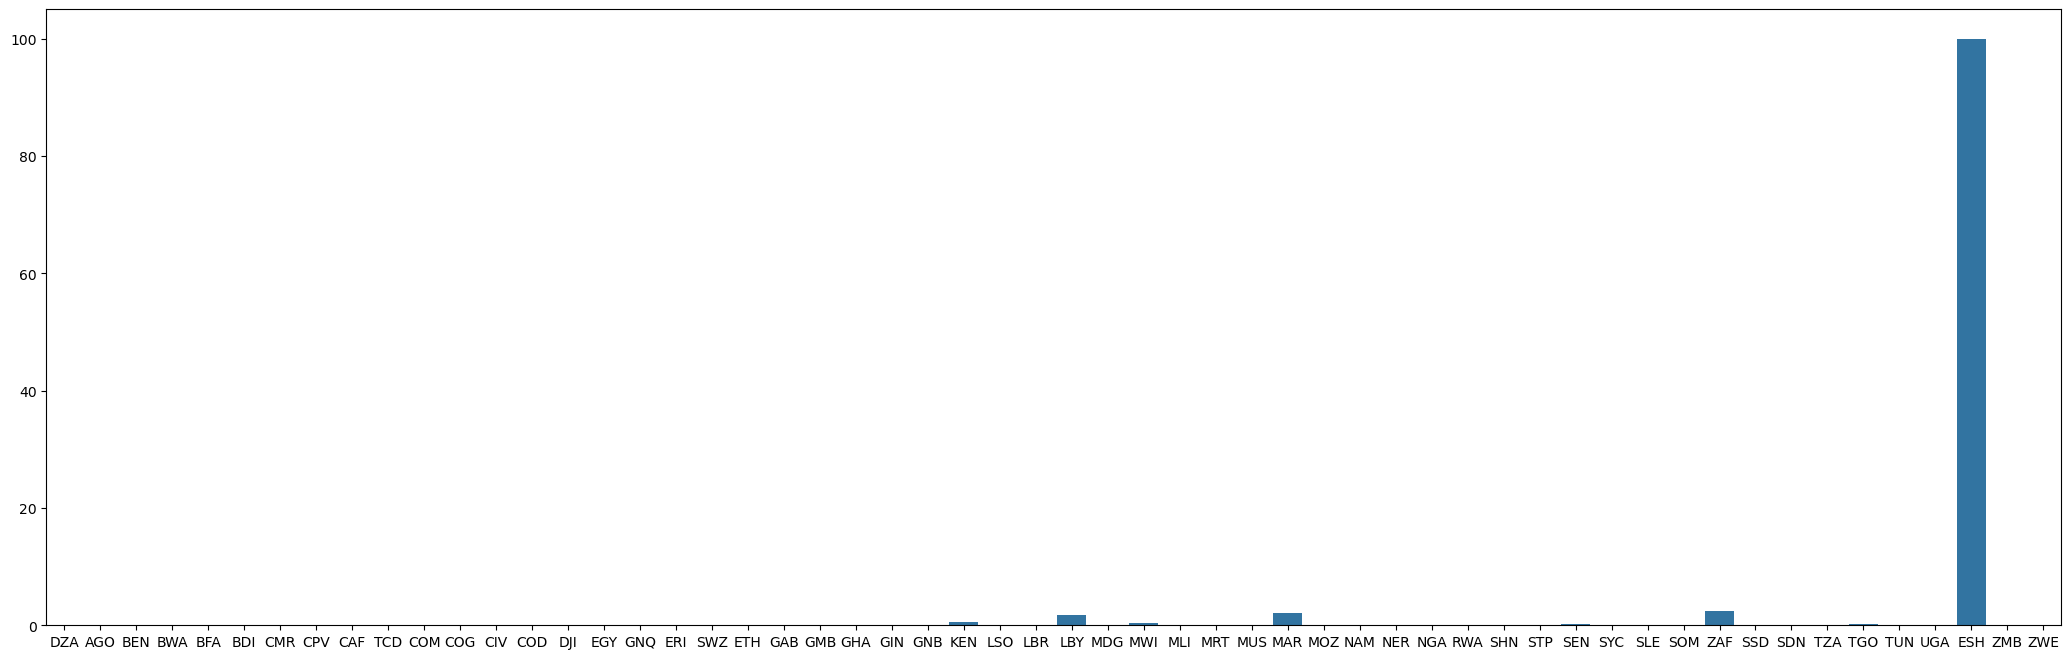

In [785]:
plotting_barplot_continent(unique_values_Africa, values_Africa)

#### 5.5 Total Cases North America

In [786]:
unique_values_North_America = countries_per_continent("North America")
unique_values_North_America

array(['AIA', 'ATG', 'ABW', 'BHS', 'BRB', 'BLZ', 'BMU', 'BES', 'VGB',
       'CAN', 'CYM', 'CRI', 'CUB', 'CUW', 'DMA', 'DOM', 'SLV', 'GRL',
       'GRD', 'GTM', 'HTI', 'HND', 'JAM', 'MEX', 'MSR', 'NIC', 'PAN',
       'PRI', 'KNA', 'LCA', 'SPM', 'VCT', 'SXM', 'TTO', 'TCA', 'USA',
       'VIR'], dtype=object)

In [787]:
values_North_America = continent_values(unique_values_North_America)

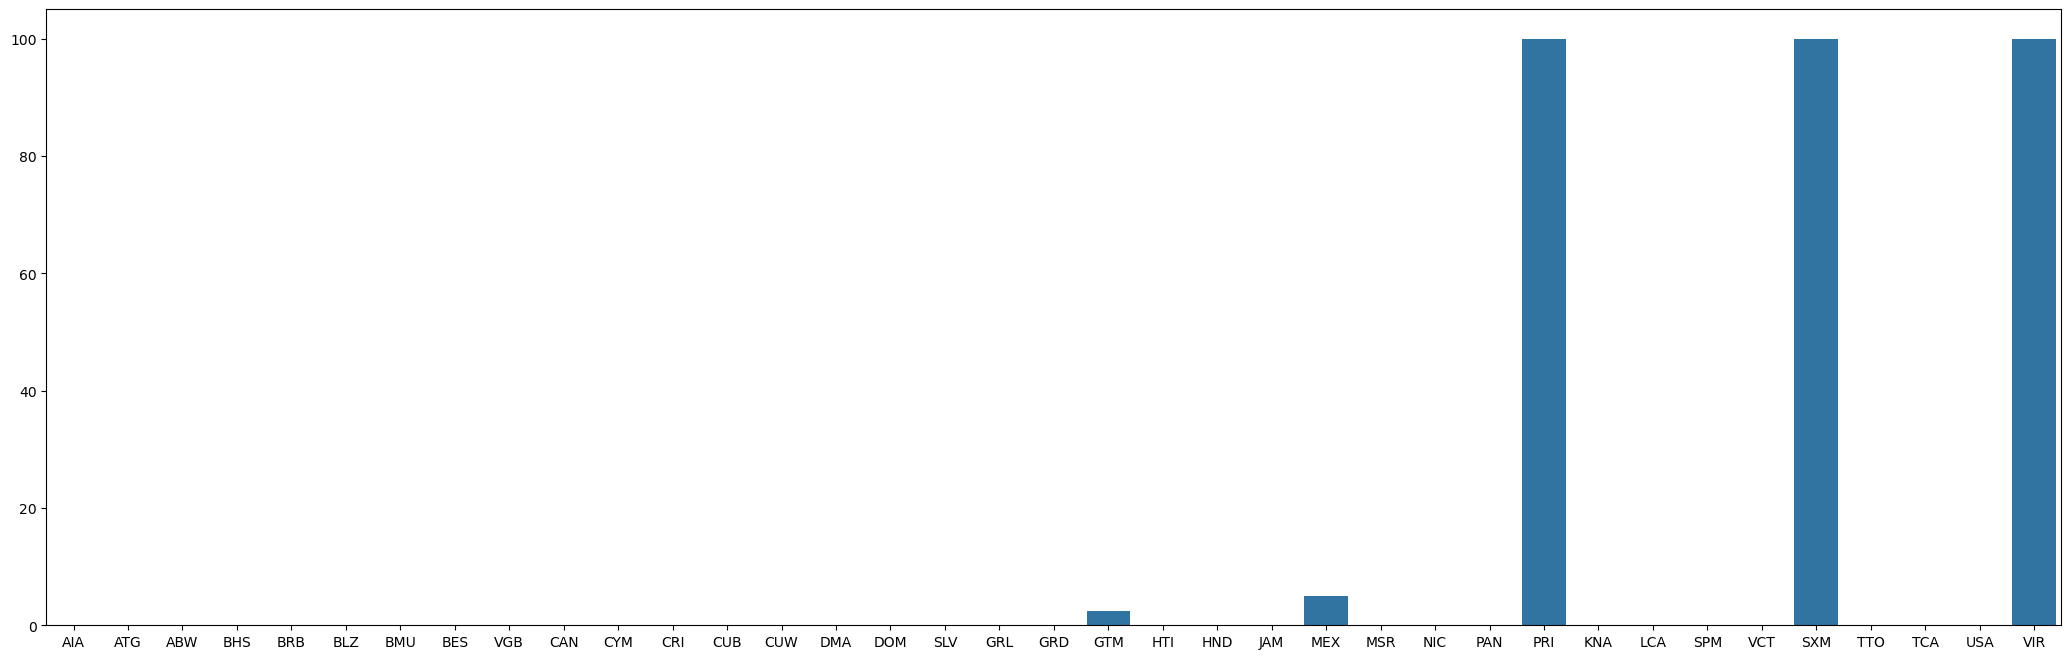

In [788]:
plotting_barplot_continent(unique_values_North_America, values_North_America)

### 6. Factual accuracy

#### 6.1 Do total cases and new cases lead to the same numbers?

Looking at Canada the reporting started on 23 of January but the first death was on March 9. A quick search on the internet confirms that 9 March was the date on which the frist Canadian person died. That makes 46 days on which there is no data on deaths. But there are 1132 entries for Canada and hence 46/1132 = 4%. In the case of Switzerland 10 no values for deaths and 1099 rows so that would make 1% of the data missing. For Germany 42/1128 = 4%. All of this data is not missing, it is just wrongly classified as NA when these should be zero.

In [789]:
def comparison_total_new_cases(country): 
    filtered_country = data_without_OWID.loc[df["location"] == "Sweden"]
    filtered_country_total_cases_from_tc = filtered_country.iloc[-1, 4]
    print ("total cases from the total cases column: ", filtered_country_total_cases_from_tc)
    print ("total cases when summing over new cases: ", filtered_country["new_cases"].sum())

comparison_total_new_cases("Sweden")

total cases from the total cases column:  2697827.0
total cases when summing over new cases:  2697827.0


#### 6.2 How accurate are vaccination statistics?

According to Wikipedia, the first vaccination in Switzerland, Germany and France tool place on December 23 2020, December 22, 2020 and December 17, 2020 respectively. The dataset confirms these:

In [790]:
def first_vaccination_statistics_accuracy(country):
    filtered_country = data_without_OWID.loc[df['location'] == country]
    filtered_country = filtered_country.reset_index(drop=True)
    first_vaccination_index = filtered_country["total_vaccinations"].first_valid_index()
    return filtered_country.iloc[first_vaccination_index,:5]
    
first_vaccination_statistics_accuracy("France")

iso_code              FRA
continent          Europe
location           France
date           2020-12-27
total_cases     2599937.0
Name: 338, dtype: object

### 7. Country analysis

#### 7.1 Function to replace missing data with zeros

In [791]:
#here is how to replace the mssing values with zero values
def replace_missing_data(country):
    filtered_country = data_without_OWID.loc[df['location'] == country]
    filtered_country = filtered_Italy.reset_index(drop=True)
    missing_vals = ["NA", "", None, np.NaN]
    missing_country = filtered_country.isin(missing_vals)


#### 7.2 Function for missing values excluding missing at the end and at the beginning for a specific country

In [792]:
def filtering_missing_country(country):
    filtered_country = data_without_OWID.loc[df['location'] == country]
    filtered_country = filtered_country.reset_index(drop=True)
    filtered_country_summary = filtered_country.isnull().sum()
    first_valid_indices_country = filtered_country.apply(lambda x: x.first_valid_index())
    last_valid_indices_country = filtered_country.apply(lambda x: x.last_valid_index())
    length = len(filtered_country) - 1

    filtered_country_summary_df = filtered_country_summary.to_frame()
    first_valid_indices_country_df = first_valid_indices_country.to_frame()
    last_valid_indices_country_df = last_valid_indices_country.to_frame()
    list_of_dataframes = [filtered_country_summary_df, first_valid_indices_country_df, last_valid_indices_country]

    comparison_country = pd.merge(filtered_country_summary_df, first_valid_indices_country_df, left_index=True, right_index=True)
    comparison_country = comparison_country.rename(columns={"0_x": '# of missing entries', "0_y": "first entry"})
    diff_first = filtered_country_summary_df - first_valid_indices_country_df
    last_valid_indices_country_df_diff = length - last_valid_indices_country_df
    diff_overall = filtered_country_summary_df - first_valid_indices_country_df - last_valid_indices_country_df_diff
    comparison_country = comparison_country.assign(diff_first = diff_first, \
                last_entry= last_valid_indices_country_df, diff_last = last_valid_indices_country_df_diff, \
                diff_overall = diff_overall)
    return (comparison_country)

In [793]:
filtering_missing_country("Finland")

,# of missing entries,first entry,diff_first,last_entry,diff_last,diff_overall
iso_code,0,0.0,0.0,1125.0,0.0,0.0
continent,0,0.0,0.0,1125.0,0.0,0.0
location,0,0.0,0.0,1125.0,0.0,0.0
date,0,0.0,0.0,1125.0,0.0,0.0
total_cases,0,0.0,0.0,1125.0,0.0,0.0
new_cases,4,0.0,4.0,1121.0,4.0,0.0
new_cases_smoothed,9,5.0,4.0,1121.0,4.0,0.0
total_deaths,38,38.0,0.0,1125.0,0.0,0.0
new_deaths,43,38.0,5.0,1121.0,4.0,1.0
new_deaths_smoothed,48,43.0,5.0,1121.0,4.0,1.0


#### 7.3 Function total diff for many countries

In [794]:
def locations_per_continent(continent):
    filtered_continent = data_without_OWID.loc[df['continent'] == continent]
    unique_values_continent = filtered_continent['location'].unique()
    return unique_values_continent

In [795]:
unique_locations_Europe = locations_per_continent("Europe")
empty_df = pd.DataFrame()

def several_countries(list, dataframe):
    count = 0
    for i in (list):
        country = filtering_missing_country(i)
        #print (country)
        country_diff_overall_column = country["diff_overall"]
        #print (country_diff_overall_column)
        country_diff_overall_column_df = country_diff_overall_column.to_frame()
        if count == 0:
            combined_df = pd.concat([empty_df, country_diff_overall_column_df], axis=1)
            count = 1
        elif count > 0:
            combined_df = pd.concat([combined_df, country_diff_overall_column_df], axis=1)
        #print (country_diff_overall_column_df)
        combined_df = combined_df.rename(columns={'diff_overall': i})
    return (combined_df)

several_countries(unique_locations_Europe, empty_df)

,Albania,Andorra,Austria,Belarus,Belgium,Bosnia and Herzegovina,Bulgaria,Croatia,Cyprus,Czechia,Denmark,Estonia,Faeroe Islands,Finland,France,Germany,Gibraltar,Greece,Guernsey,Hungary,Iceland,Ireland,Isle of Man,Italy,Jersey,Latvia,Liechtenstein,Lithuania,Luxembourg,Malta,Moldova,Monaco,Montenegro,Netherlands,North Macedonia,Norway,Poland,Portugal,Romania,Russia,San Marino,Serbia,Slovakia,Slovenia,Spain,Sweden,Switzerland,Ukraine,United Kingdom,Vatican
iso_code,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
continent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
location,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
date,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
total_cases,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
new_cases,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,1.0,0.0,0.0,12.0,0.0,4.0,0.0,NaN,0.0,2.0,4.0,0.0,1.0,NaN,0.0,2.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,2.0,0.0,5.0,0.0,0.0,0.0,4.0,0.0
new_cases_smoothed,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,1.0,0.0,0.0,20.0,0.0,4.0,0.0,NaN,0.0,2.0,4.0,0.0,1.0,NaN,0.0,7.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,2.0,0.0,5.0,0.0,0.0,0.0,4.0,0.0
total_deaths,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
new_deaths,0.0,1.0,4.0,0.0,1.0,2.0,0.0,0.0,0.0,13.0,2.0,2.0,0.0,1.0,8.0,3.0,0.0,0.0,NaN,0.0,3.0,7.0,0.0,1.0,NaN,1.0,1.0,16.0,2.0,1.0,2.0,1.0,1.0,5.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,9.0,7.0,18.0,0.0,4.0,NaN
new_deaths_smoothed,0.0,1.0,9.0,0.0,1.0,2.0,0.0,0.0,0.0,30.0,2.0,2.0,0.0,1.0,9.0,3.0,0.0,0.0,NaN,0.0,3.0,7.0,0.0,1.0,NaN,1.0,1.0,27.0,2.0,1.0,2.0,1.0,1.0,9.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,9.0,7.0,27.0,0.0,4.0,NaN


In [796]:
country_of_interest = "Finland"
filtered = data_without_OWID.loc[df['location'] == country_of_interest]
filtered = filtered.reset_index(drop=True)
vaccinations = filtered["total_vaccinations"]
vaccinations.head(500)

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
5            NaN
6            NaN
7            NaN
8            NaN
9            NaN
10           NaN
11           NaN
12           NaN
13           NaN
14           NaN
15           NaN
16           NaN
17           NaN
18           NaN
19           NaN
20           NaN
21           NaN
22           NaN
23           NaN
24           NaN
25           NaN
26           NaN
27           NaN
28           NaN
29           NaN
30           NaN
31           NaN
32           NaN
33           NaN
34           NaN
35           NaN
36           NaN
37           NaN
38           NaN
39           NaN
40           NaN
41           NaN
42           NaN
43           NaN
44           NaN
45           NaN
46           NaN
47           NaN
48           NaN
49           NaN
50           NaN
51           NaN
52           NaN
53           NaN
54           NaN
55           NaN
56           NaN
57           NaN
58           N

Finland and other countries only reporting once per week

#### 7.4 Imputation every nth datapoint (in progress)